In [1]:
import pickle

import gensim
import analyzer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from collections import defaultdict

In [2]:
emails_path = Path(Path.cwd().parent, 'maildir')

In [3]:
df = pd.read_pickle('enron_mails.p')
# normally would be 0.4
train, test = train_test_split(df, test_size=0.8, random_state=2022)


# Pre-processing

## Freeling

In [4]:
%%time
flan = analyzer.FreelingAnalyzer(emails_path, 'en')

CPU times: user 31.3 s, sys: 668 ms, total: 32 s
Wall time: 31.5 s


In [9]:
%%time
tokens = []
for _, mail in train['text'].items():
    tokens.append(flan.obtain_tokens(mail))

SPLITTER: Ridiculously long sentence between markers at token ',' at input offset 25.
SPLITTER: Ridiculously long sentence between markers at token '/' at input offset 11.
SPLITTER: Ridiculously long sentence between markers at token 'A' at input offset 1.
SPLITTER: Ridiculously long sentence between markers at token '/' at input offset 11.
SPLITTER: Ridiculously long sentence between markers at token 'Enron@EnronXGate' at input offset 13.
SPLITTER: Ridiculously long sentence between markers at token 'on' at input offset 13.
SPLITTER: Ridiculously long sentence between markers at token '$2.7450' at input offset 25.
SPLITTER: Ridiculously long sentence between markers at token 'NY' at input offset 0.
SPLITTER: Ridiculously long sentence between markers at token '/' at input offset 15.
SPLITTER: Ridiculously long sentence between markers at token '/' at input offset 11.
SPLITTER: Ridiculously long sentence between markers at token 'Ask' at input offset 24.
SPLITTER: Ridiculously long sen

CPU times: user 41min 15s, sys: 3.3 s, total: 41min 19s
Wall time: 41min 19s


See configuration of splitter to deal with `"`. See `splitter.dat`

{'Start': 1,
 'Date': 1,
 ':': 2,
 '4/30/01': 1,
 ';': 2,
 'HourAhead': 1,
 'hour': 1,
 '11': 1,
 'No': 2,
 'ancillary': 1,
 'schedules': 1,
 'awarded': 1,
 '.': 2,
 'variances': 1,
 'detected': 1}

In [ ]:

#lemmas = train['text'].apply(flan.obtain_lemmas)
#lemmas

## Ginsem tokenizer

In [4]:
%%time
def create_corpus(input_docs, tokens_only=False):
    for i, text in input_docs:
        tokens = gensim.utils.simple_preprocess(text)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

            
train_corpus = list(create_corpus(train['text'].items(), tokens_only=True))
# test_corpus = list(create_corpus(test['text'].items(), tokens_only=True))


CPU times: user 24.2 s, sys: 343 ms, total: 24.5 s
Wall time: 24.6 s


In [5]:
def token_freqs(doc):
    """Extract a dict mapping tokens from doc to their frequencies."""
    freq = defaultdict(int)
    for tok in doc:
        freq[tok] += 1
    return freq


In [6]:
data_size_mb = sum(len(s) for s in train_corpus) / 1e6

In [7]:
print("DictVectorizer")
t0 = time()
vectorizer = DictVectorizer()
# vectorizer.fit_transform(tokens)
vectorizer.fit_transform(token_freqs(d) for d in train_corpus)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_size_mb / duration))
print("Found %d unique terms" % len(vectorizer.get_feature_names_out()))
print()


DictVectorizer
done in 10.312361s at 1.234MB/s
Found 117678 unique terms



In [8]:
n_features = 2 ** 18

def n_nonzero_columns(X):
    """Returns the number of non-zero columns in a CSR matrix X."""
    return len(np.unique(X.nonzero()[1]))


print("FeatureHasher on frequency dicts")
t0 = time()
hasher = FeatureHasher(n_features=n_features)
X = hasher.transform(token_freqs(d) for d in train_corpus)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_size_mb / duration))
print("Found %d unique terms" % n_nonzero_columns(X))
print()


FeatureHasher on frequency dicts
done in 3.661170s at 3.475MB/s
Found 94642 unique terms



# DBSCAN

In [9]:
%%time
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


Estimated number of clusters: 285
Estimated number of noise points: 93032


NameError: name 'labels_true' is not defined

See parameters of DBSCAN.

In [10]:
%%time
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


Estimated number of clusters: 285
Estimated number of noise points: 93032
Silhouette Coefficient: -0.436


print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)

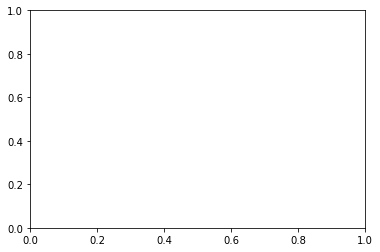

In [ ]:
# #############################################################################
# Plot result


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# LDA 

In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)
